 # Data Analysis with SQL: IMDB Top 1000 Movies

In [1]:
# Importing dependencies for this project.
import sqlite3
import matplotlib.pyplot as plt

## Objective
This notebook is a quick reference example for analysing data using an SQL database.  
This is a continuation of [Data Cleaning with SQL](https://www.kaggle.com/code/oliverdaubney/data-cleaning-with-sql) using data from kaggle<sup>1</sup>. <br>
Link: __[Original Kaggle Dataset](https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows)__ <br>

## Contents
1. [Database Connection](#Database-Connection)
2. [Basic Data Visualisation](#Basic-Data-Visualisation)
    1. [Pie Charts using 'GROUP BY'](#Pie-Charts-using-'GROUP-BY')
    2. [Histograms for Release Year and Runtimes](#Histograms-for-Release-Year-and-Runtimes)
    3. [Scatter Plots using WHERE to Filter Data](#Scatter-Plots-using-WHERE-to-Filter-Data)
    4. [Box Plots using CASE to Group Data](#Box-Plots-using-CASE-to-Group-Data)
4. [SQL Querying](#SQL-Querying)
    1. [Query 1 - Using WHERE and MAX](#1.-What-was-the-longest-runtime-movie-between-1950-and-1970?)
    2. [Query 2 - Using ORDER BY and COUNT](#2.-Which-year-had-the-most-number-of-highly-rated-releases?)
    3. [Query 3 - Using WHERE and ORDER BY](#3.-Which-film-rated-above-8.0-had-the-fewest-votes?)
    4. [Query 4 - Using GROUP BY and MAX](#4.-What-was-the-highest-rated-film-for-each-of-the-certifications-(U,-PG-and-R)?)
5. [Close Connection to the Database](#Close-Connection-to-the-Database)
6. [References](#References)

## Database Connection

In [2]:
# Connecting to the database.
connection = sqlite3.connect("data/movies.db")
connection.row_factory = sqlite3.Row
minion = connection.cursor()

In [3]:
# Accessing all the column names.
SQL_command = """
    PRAGMA
        table_info(movies_data);
"""
minion.execute(SQL_command)
column_names = []
output = minion.fetchone()
while output:
    column_names.append(output[1])
    output = minion.fetchone()
column_names

['title',
 'release_year',
 'certificate',
 'runtime',
 'imdb_rating',
 'num_votes',
 'gross']

## Basic Data Visualisation
In this section, the SQL database is used to serve data that can be plotted in visualisations.

### Pie Charts using 'GROUP BY'
Using **GROUP BY** to see how many records are present for each certificate category.

In [4]:
SQL_command = """
    SELECT
        certificate,
        COUNT(*)
    FROM
        movies_data
    GROUP BY
        certificate;
"""
minion.execute(SQL_command)

labels, counts = [], []
data = minion.fetchone()
while data:
    labels.append(data[0])
    counts.append(data[1])
    data = minion.fetchone()

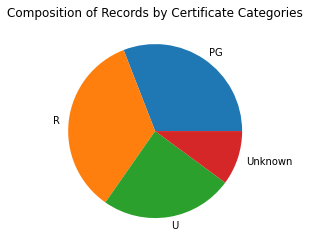

In [5]:
plt.pie(counts, labels=labels)
plt.title('Composition of Records by Certificate Categories')
plt.show()

### Histograms for Release Year and Runtimes
The distribution of values for the release year and runtime can be visualised using histograms.  
*Note*: The use of **CAST** is required as release_year is stored as a string.

In [6]:
SQL_command = """
    SELECT
        CAST(release_year AS INTEGER) AS release_year,
        runtime
    FROM
        movies_data;
"""
minion.execute(SQL_command)

years, runtimes = [], []
data = minion.fetchone()
while data:
    years.append(data['release_year'])
    runtimes.append(data['runtime'])
    data = minion.fetchone()

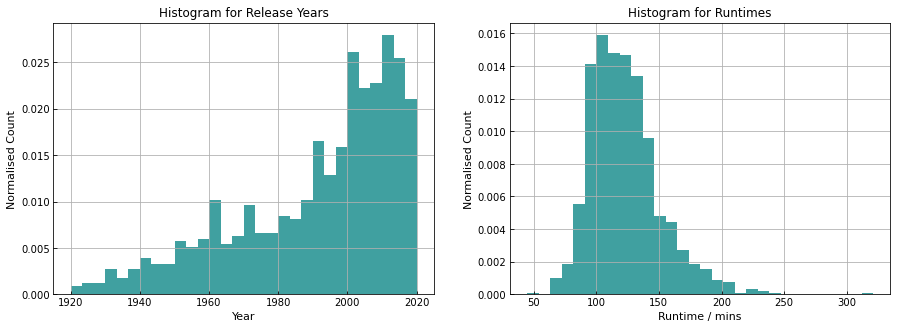

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

ax = axes[0]
ax.hist(years, 30, density=True, facecolor='teal', alpha=0.75)
ax.set_xlabel('Year', fontsize=11)
ax.set_ylabel('Normalised Count', fontsize=11)
ax.set_title('Histogram for Release Years')
ax.tick_params(direction='in')
ax.grid(True)

ax = axes[1]
ax.hist(runtimes, 30, density=True, facecolor='teal', alpha=0.75)
ax.set_xlabel('Runtime / mins', fontsize=11)
ax.set_ylabel('Normalised Count', fontsize=11)
ax.set_title('Histogram for Runtimes')
ax.tick_params(direction='in')
ax.grid(True)

plt.show()

### Scatter Plots using WHERE to Filter Data
Using a scatter plot it is possible to visualise how the gross value of the production changes with release year.  
The **WHERE** syntax is used to filter the results so that we ignore any records without a gross value.

In [8]:
SQL_command = """
    SELECT
        CAST(release_year AS INTEGER) AS release_year,
        gross
    FROM
        movies_data
    WHERE
        gross IS NOT NULL;
"""
minion.execute(SQL_command)

years, gross = [], []
data = minion.fetchone()
while data:
    years.append(data['release_year'])
    gross.append(data['gross']/1000000)
    data = minion.fetchone()

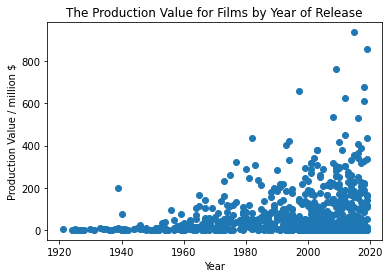

In [9]:
plt.scatter(years, gross)
plt.title('The Production Value for Films by Year of Release')
plt.xlabel('Year')
plt.ylabel('Production Value / million $')
plt.show()

It is a bit hard to see what is going on in this plot, so we can take the average production value for each year using the **AVG** function in SQL.  
*Note*: This could be improved by using the standard deviation as an error bar.

In [10]:
SQL_command = """
    SELECT
        CAST(release_year AS INTEGER) AS release_year,
        AVG(gross) AS average_gross
    FROM
        movies_data
    WHERE
        gross IS NOT NULL
    GROUP BY
        release_year;
"""
minion.execute(SQL_command)

years, gross = [], []
data = minion.fetchone()
while data:
    years.append(data['release_year'])
    gross.append(data['average_gross']/1000000)
    data = minion.fetchone()

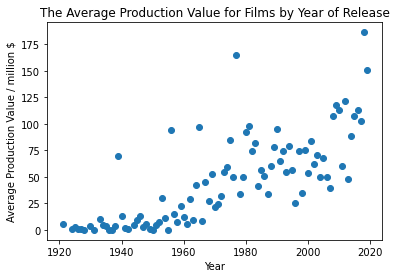

In [11]:
plt.scatter(years, gross)
plt.title('The Average Production Value for Films by Year of Release')
plt.xlabel('Year')
plt.ylabel('Average Production Value / million $')
plt.show()

This shows that the production value is typically increasing in more recent years. However, this data does not take into account inflation which would have a big impact on this conclusion.

### Box Plots using CASE to Group Data
I was a bit interested to see if there was much difference in the runtime between productions with different certifications.

In [12]:
SQL_command = """
    SELECT
        (CASE WHEN certificate = 'U'
            THEN runtime
            ELSE NULL
        END) AS u_run,
        (CASE WHEN certificate = 'PG'
            THEN runtime
            ELSE NULL
        END) AS pg_run,
        (CASE WHEN certificate = 'R'
            THEN runtime
            ELSE NULL
        END) AS r_run,
        (CASE WHEN certificate = 'Unknown'
            THEN runtime
            ELSE NULL
        END) AS unk_run
    FROM
        movies_data;
"""
minion.execute(SQL_command)

u, pg, r = [], [], []
data = minion.fetchone()
while data:
    if data['u_run']:
        u.append(data['u_run'])
    elif data['pg_run']:
        pg.append(data['pg_run'])
    elif data['r_run']:
        r.append(data['r_run'])
    data = minion.fetchone()

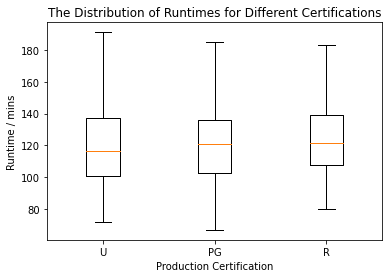

In [13]:
data, labels = [u, pg, r], ['U', 'PG', 'R']
plt.boxplot(data, labels=labels, showfliers=False)
plt.title('The Distribution of Runtimes for Different Certifications')
plt.xlabel('Production Certification')
plt.ylabel('Runtime / mins')
plt.show()

There does not appear to be much difference between the certifications regarding their runtimes.

## SQL Querying
In this section, the SQL database is used to serve data in response to specific querying.  
This can be used to answer specific questions such as:

### 1. What was the longest runtime movie between 1950 and 1970?

In [14]:
SQL_command = """
    SELECT
        title,
        MAX(runtime)
    FROM
        movies_data
    WHERE
        CAST(release_year AS INTEGER) >= 1950 AND
        CAST(release_year AS INTEGER) <= 1970;
"""
minion.execute(SQL_command)

data = minion.fetchone()
print(f"The longest runtime between 1950 and 1970 was {data[1]} minutes for {data[0]}.")

The longest runtime between 1950 and 1970 was 228 minutes for Lawrence of Arabia.


### 2. Which year had the most number of highly rated releases?

In [15]:
SQL_command = """
    SELECT
        release_year,
        COUNT(release_year) AS num_releases
    FROM
        movies_data
    GROUP BY
        release_year
    ORDER BY
        num_releases DESC;
"""
minion.execute(SQL_command)

data = minion.fetchone()
print(f"The year {data[0]} had the most highly rated releases with a total of {data[1]}.")

The year 2014 had the most highly rated releases with a total of 32.


### 3. Which film rated above 8.0 had the fewest votes?

In [16]:
SQL_command = """
    SELECT
        title,
        imdb_rating,
        num_votes
    FROM
        movies_data
    WHERE
        imdb_rating >= 8.0
    ORDER BY
        num_votes ASC;
"""
minion.execute(SQL_command)

data = minion.fetchone()
print(f"The film '{data['title']}' had a rating of {data['imdb_rating']} but only {data['num_votes']} votes.")

The film 'Ba wang bie ji' had a rating of 8.1 but only 25088 votes.


### 4. What was the highest rated film for each of the certifications (U, PG and R)?

In [17]:
SQL_command = """
    SELECT
        title,
        MAX(imdb_rating),
        certificate
    FROM
        movies_data
    WHERE
        certificate != 'Unknown'
    GROUP BY
        certificate;
"""
minion.execute(SQL_command)

data = minion.fetchone()
while data:
    print(f"The highest rated production for {data[2]} was '{data[0]}' with an imdb rating of {data[1]}.")
    data = minion.fetchone()

The highest rated production for PG was 'The Dark Knight' with an imdb rating of 9.0.
The highest rated production for R was 'The Shawshank Redemption' with an imdb rating of 9.3.
The highest rated production for U was '12 Angry Men' with an imdb rating of 9.0.


## Close Connection to the Database

In [18]:
connection.close()

## References
1. The dataset was prepared by Harshit Shankhdhar from IMDB available information for their top-rated 1000 movies. Harshit Shankhdhar (2020). <i>IMDB Movies Dataset</i> [Data set]. Kaggle. https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows